In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflowjs as tfjs

In [36]:
#Data preprocessing
train_dir = os.path.join('yes_and_no_hands', 'train')
validation_dir = os.path.join('yes_and_no_hands', 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2677 files belonging to 2 classes.


In [37]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 181 files belonging to 2 classes.


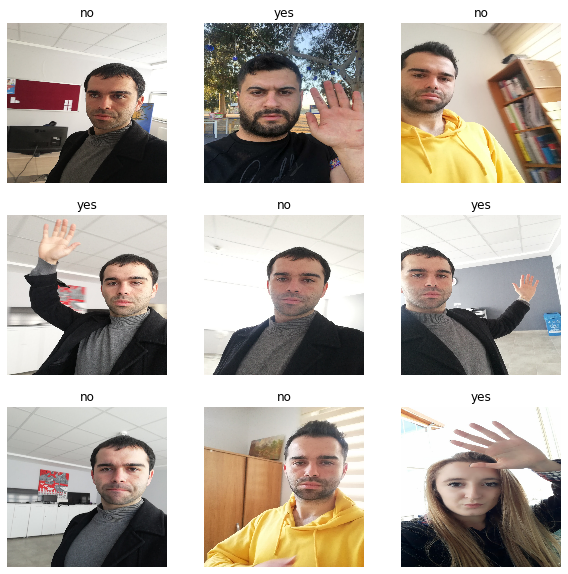

In [38]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 1)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 6


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

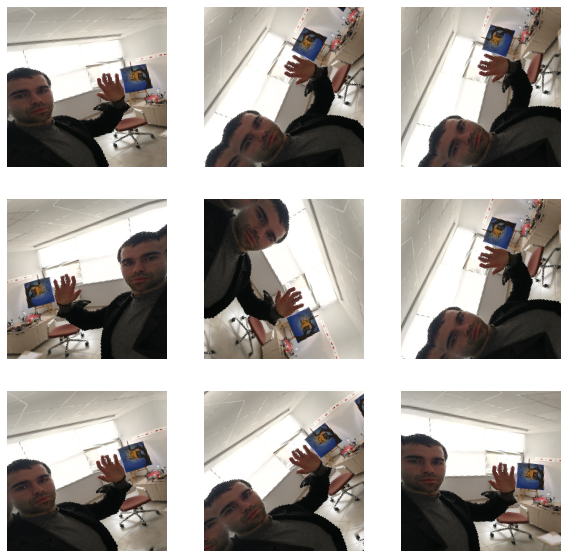

In [42]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [43]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [44]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [45]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [47]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [48]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [49]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [50]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [53]:
len(model.trainable_variables)

2

In [54]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 17s 421ms/step - loss: 0.6195 - accuracy: 0.4908


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.52


In [56]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
84/84 [==============================] - 269s 3s/step - loss: 0.7104 - accuracy: 0.5689 - val_loss: 0.4441 - val_accuracy: 0.7919
Epoch 2/10
84/84 [==============================] - 237s 3s/step - loss: 0.6093 - accuracy: 0.6675 - val_loss: 0.3917 - val_accuracy: 0.8591
Epoch 3/10
84/84 [==============================] - 238s 3s/step - loss: 0.5224 - accuracy: 0.7273 - val_loss: 0.3469 - val_accuracy: 0.8993
Epoch 4/10
84/84 [==============================] - 239s 3s/step - loss: 0.4816 - accuracy: 0.7609 - val_loss: 0.3242 - val_accuracy: 0.9128
Epoch 5/10
84/84 [==============================] - 238s 3s/step - loss: 0.4274 - accuracy: 0.8106 - val_loss: 0.2927 - val_accuracy: 0.9262
Epoch 6/10
84/84 [==============================] - 238s 3s/step - loss: 0.3912 - accuracy: 0.8282 - val_loss: 0.2872 - val_accuracy: 0.9396
Epoch 7/10
84/84 [==============================] - 238s 3s/step - loss: 0.3809 - accuracy: 0.8379 - val_loss: 0.2823 - val_accuracy: 0.9396
Epoch 8/10
84

In [58]:
base_model.trainable = True

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [60]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [62]:
len(model.trainable_variables)

56

In [63]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
84/84 [==============================] - 265s 3s/step - loss: 0.2218 - accuracy: 0.9093 - val_loss: 0.0915 - val_accuracy: 0.9799
Epoch 11/15
84/84 [==============================] - 255s 3s/step - loss: 0.0817 - accuracy: 0.9680 - val_loss: 0.0792 - val_accuracy: 0.9866
Epoch 12/15
84/84 [==============================] - 256s 3s/step - loss: 0.0505 - accuracy: 0.9823 - val_loss: 0.0530 - val_accuracy: 0.9799
Epoch 13/15
84/84 [==============================] - 255s 3s/step - loss: 0.0304 - accuracy: 0.9881 - val_loss: 0.0512 - val_accuracy: 0.9799
Epoch 14/15
84/84 [==============================] - 256s 3s/step - loss: 0.0287 - accuracy: 0.9932 - val_loss: 0.0605 - val_accuracy: 0.9732
Epoch 15/15
84/84 [==============================] - 255s 3s/step - loss: 0.0223 - accuracy: 0.9918 - val_loss: 0.0769 - val_accuracy: 0.9732


In [64]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 13s 430ms/step - loss: 0.0636 - accuracy: 0.9779
Test accuracy : 0.9779005646705627


Predictions:
 [0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1]
Labels:
 [0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1]


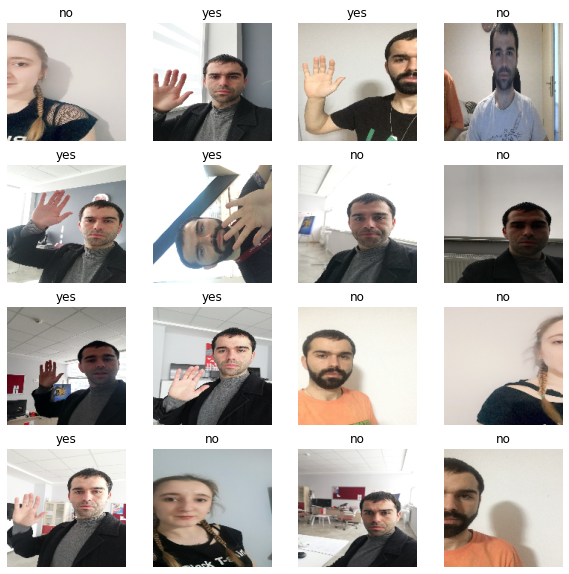

In [65]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [66]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [67]:
#SAVE WITH KERAS
filepath = 'H5'
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: H5\assets


In [68]:
#SAVE THE HEIGHTS
model.save_weights("model.h5")
tensor_dir = 'tensorflowjs'
tfjs.converters.save_keras_model(model , tensor_dir)

C:\Users\Duzgun\anaconda3\envs\newEnv\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [69]:
model.save('my_model.h5')